In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor

In [2]:
df = pd.read_csv('./car details v4.csv')

In [3]:
df = df.dropna(axis=0)

In [4]:
# Power column numeric data extration from string mixed data
pattern_pw = r'(\d+)(?:\s*bhp)?\s*@\s*(\d+)(?:\s*rpm)?'
df[['Power', 'Power RPM']] = df['Max Power'].str.extract(pattern_pw).astype(float)

In [5]:
# Torque column numeric data extration from string mixed data
pattern_trq = r'(\d+)(?:\s*Nm)?\s*@\s*(\d+)(?:\s*rpm)?'
df[['Torque', 'Torque RPM']] = df['Max Torque'].str.extract(pattern_trq).astype(float)

In [6]:
df = df.drop(columns=['Max Power', 'Max Torque'], axis=1)

In [7]:
df

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,Power,Power RPM,Torque,Torque RPM
0,Honda,Amaze 1.2 VX i-VTEC,505000,2017,87150,Petrol,Manual,Pune,Grey,First,...,FWD,3990.0,1680.0,1505.0,5.0,35.0,87.0,6000.0,109.0,4500.0
1,Maruti Suzuki,Swift DZire VDI,450000,2014,75000,Diesel,Manual,Ludhiana,White,Second,...,FWD,3995.0,1695.0,1555.0,5.0,42.0,74.0,4000.0,190.0,2000.0
2,Hyundai,i10 Magna 1.2 Kappa2,220000,2011,67000,Petrol,Manual,Lucknow,Maroon,First,...,FWD,3585.0,1595.0,1550.0,5.0,35.0,79.0,6000.0,7619.0,4000.0
3,Toyota,Glanza G,799000,2019,37500,Petrol,Manual,Mangalore,Red,First,...,FWD,3995.0,1745.0,1510.0,5.0,37.0,82.0,6000.0,113.0,4200.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],1950000,2018,69000,Diesel,Manual,Mumbai,Grey,First,...,RWD,4735.0,1830.0,1795.0,7.0,55.0,148.0,3400.0,343.0,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,Maruti Suzuki,Ritz Vxi (ABS) BS-IV,245000,2014,79000,Petrol,Manual,Faridabad,White,Second,...,FWD,3775.0,1680.0,1620.0,5.0,43.0,85.0,6000.0,113.0,4500.0
2054,Mahindra,XUV500 W8 [2015-2017],850000,2016,90300,Diesel,Manual,Surat,White,First,...,FWD,4585.0,1890.0,1785.0,7.0,70.0,138.0,3750.0,330.0,1600.0
2055,Hyundai,Eon D-Lite +,275000,2014,83000,Petrol,Manual,Ahmedabad,White,Second,...,FWD,3495.0,1550.0,1500.0,5.0,32.0,55.0,5500.0,75.0,4000.0
2056,Ford,Figo Duratec Petrol ZXI 1.2,240000,2013,73000,Petrol,Manual,Thane,Silver,First,...,FWD,3795.0,1680.0,1427.0,5.0,45.0,70.0,6250.0,102.0,4000.0


In [10]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_columns(df):
    # Initialize a LabelEncoder
    label_encoder = LabelEncoder()
    
    # List of object type columns with missing values
    object_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    # Encode each object column
    for column in object_columns:
        df[column] = label_encoder.fit_transform(df[column])
    
    return df

In [11]:
encoded_df = encode_categorical_columns(df)

In [12]:
encoded_df

,Make,Model,Price,Year,Kilometer,Fuel Type,Transmission,Location,Color,Owner,...,Drivetrain,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,Power,Power RPM,Torque,Torque RPM
0,7,92,505000,2017,87150,5,1,56,7,0,...,1,3990.0,1680.0,1505.0,5.0,35.0,87.0,6000.0,109.0,4500.0
1,18,731,450000,2014,75000,2,1,40,14,1,...,1,3995.0,1695.0,1555.0,5.0,42.0,74.0,4000.0,190.0,2000.0
2,8,940,220000,2011,67000,5,1,39,8,0,...,1,3585.0,1595.0,1550.0,5.0,35.0,79.0,6000.0,7619.0,4000.0
3,29,453,799000,2019,37500,5,1,41,12,0,...,1,3995.0,1745.0,1510.0,5.0,37.0,82.0,6000.0,113.0,4200.0
4,29,503,1950000,2018,69000,2,1,45,7,0,...,2,4735.0,1830.0,1795.0,7.0,55.0,148.0,3400.0,343.0,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,18,641,245000,2014,79000,5,1,20,14,1,...,1,3775.0,1680.0,1620.0,5.0,43.0,85.0,6000.0,113.0,4500.0
2054,17,914,850000,2016,90300,2,1,66,14,0,...,1,4585.0,1890.0,1785.0,7.0,70.0,138.0,3750.0,330.0,1600.0
2055,8,379,275000,2014,83000,5,1,1,14,1,...,1,3495.0,1550.0,1500.0,5.0,32.0,55.0,5500.0,75.0,4000.0
2056,6,418,240000,2013,73000,5,1,67,13,0,...,1,3795.0,1680.0,1427.0,5.0,45.0,70.0,6250.0,102.0,4000.0


In [13]:
X = encoded_df.drop(columns=['Price'], axis=1)
y = np.log1p(encoded_df['Price'])

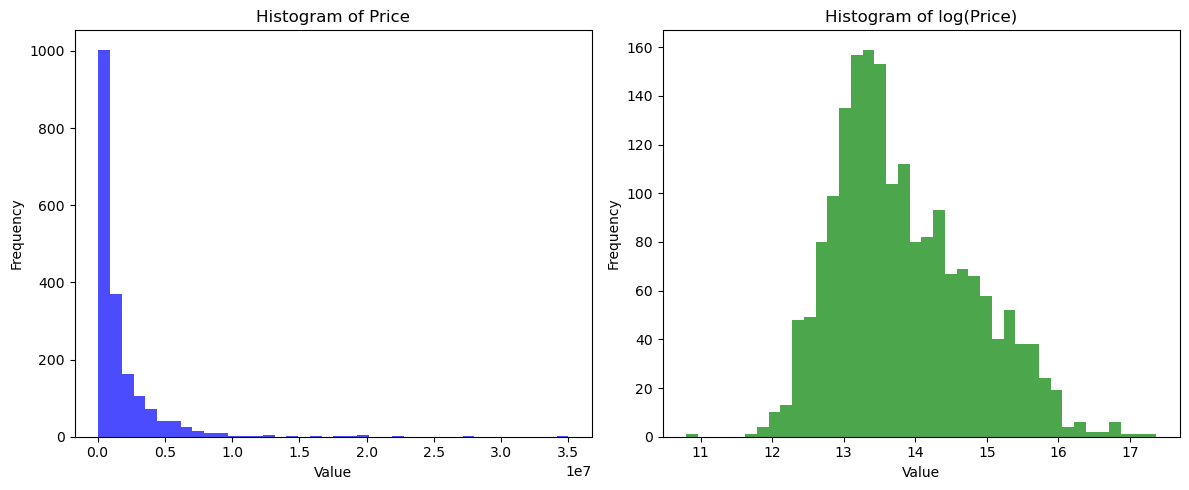

In [14]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# First subplot: Histogram of y_train
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.hist(encoded_df['Price'], bins=40, color='blue', alpha=0.7)
plt.title("Histogram of Price")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Second subplot: Histogram of train['LogPrice']
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.hist(y, bins=40, color='green', alpha=0.7)
plt.title("Histogram of log(Price)")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [17]:
xgb_model = xgb.XGBRegressor()
gbr_model = GradientBoostingRegressor()
etr_model = ExtraTreesRegressor()
rf_model = RandomForestRegressor()

xgb_model.fit(X_train, y_train)
gbr_model.fit(X_train, y_train)
etr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [18]:
models = [('XGB', xgb_model), ('GBR', gbr_model), ('ETR', etr_model), ('RF', rf_model)]
for name, model in models:
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name} - MAE: {mae}, MSE: {mse}, R^2: {r2}')


XGB - MAE: 0.14202545272955186, MSE: 0.05342336170257264, R^2: 0.9502429029177799
GBR - MAE: 0.15571544181888455, MSE: 0.05484824592513671, R^2: 0.9489158036800389
ETR - MAE: 0.1553478080609468, MSE: 0.05576144189482833, R^2: 0.9480652772610537
RF - MAE: 0.15942499589895945, MSE: 0.0686838572828404, R^2: 0.9360296835337663


In [19]:
ensemble_model = VotingRegressor(estimators=models)
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)

mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print(f'Ensemble - MAE: {mae_ensemble}, MSE: {mse_ensemble}, R^2: {r2_ensemble}')

Ensemble - MAE: 0.14310733337650589, MSE: 0.05152627029141359, R^2: 0.9520098033619041
